In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from smoother import MaxEntropy

c:\users\dbspe\smoother\smoother\max_entropy.py:70: RuntimeWarning: overflow encountered in exp
  sum([param*f(x) for param, f in zip(params, self._moment_funcs)])
C:\Users\DBSpe\studies\fcast-demo\hemlock-venv\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\users\dbspe\smoother\smoother\max_entropy.py:70: RuntimeWarning: overflow encountered in exp
  sum([param*f(x) for param, f in zip(params, self._moment_funcs)])


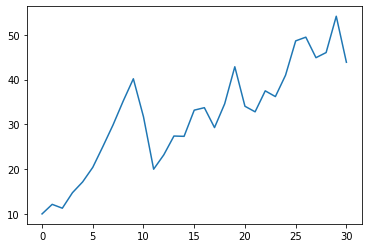

In [2]:
class Demand(MaxEntropy):
    def __init__(self, const=0, a=0, b=0, p=0, sigma=1, season=[]):
        self.const = const
        self.a = a
        self.b = b
        self.p = p
        self.sigma = sigma
        self.season = season
        
    def fit(self, x_t, t):
        mu = (
            self.const
            + self.b*(t+1) # time trend
            + self.p*(x_t-self.const) # serial correlation
            + (0 if not self.season else self.season[(t+1)%len(self.season)]) # seasonality
        )
        sigma = self.sigma + self.a*x_t # heteroskedastic error
        moment_funcs = [lambda x: x, lambda x: (x-mu)**2]
        values = [mu, sigma**2]
        return super().fit(0, mu+2.58*sigma, moment_funcs, values)
        
    
demand = Demand(10, p=.7, a=.1, b=.2, sigma=0, season=2*list(range(10)))
x_t = 10
x = [x_t]
for t in range(30):
    x_t = demand.fit(x_t, t).rvs()
    x.append(x_t)
plt.plot(x)

mean demand 41.363553595556986
std demand 4.4358392710235215
realized demand 35.971886477811864


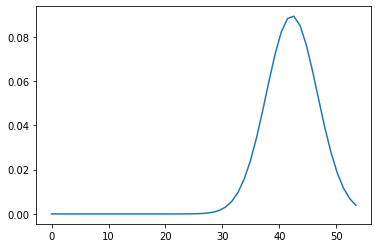

In [3]:
demand.fit(x[-1], len(x))
r_demand = demand.rvs()
print('mean demand', demand.mean())
print('std demand', demand.std())
print('realized demand', r_demand)
plt.plot(demand.x, demand.f_x)

In [4]:
def maximize(demand, price, cost, overtime, tol=.01, maxiter=100, size=1000):
    def compute_exp_profit(q):
        supply = demand.ppf(q)
        tot_cost = cost*supply + overtime*np.clip(x-supply, 0, np.inf)
        return supply, (price*x - tot_cost).mean()
        
    x = demand.rvs(size=size)
    opt_supply, max_exp_profit = 0, 0
    q, step = 0, 1
    for i in range(maxiter):
        supply, exp_profit = compute_exp_profit(q)
        delta = exp_profit - max_exp_profit
        if delta >= 0:
            opt_supply = supply
            max_exp_profit = exp_profit
        step /= 2
        q += step if delta>=0 else -step
        if i>0 and abs(delta) < tol:
            break
    return opt_supply

p, c, ot = 100, 30, 90
lb, ub, mu, sigma = 0, 52, 42, 4
fcast_demand = MaxEntropy().fit(lb, ub, [lambda x: x, lambda x: (x-mu)**2], [mu, sigma**2])
supply = maximize(fcast_demand, p, c, ot)
print('Supply', supply)

Supply 44.814453125


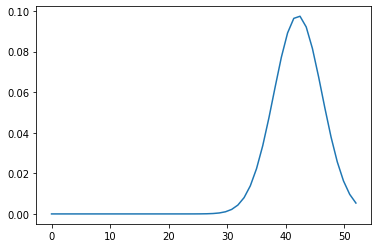

In [5]:
plt.plot(fcast_demand.x, fcast_demand.f_x)

In [6]:
r_profit = p*r_demand - c*supply - ot*max(r_demand-supply, 0)
print('Profit', r_profit)

Profit 2252.7550540311863


In [7]:
def rps(true_dist, fcast_dist):
    def get_lb(dist):
        lb = dist.ppf(0)
        return dist.ppf(.01) if lb == -np.inf else lb
    
    def get_ub(dist):
        ub = dist.ppf(1)
        return dist.ppf(.99) if ub == np.inf else ub
    
    lb = min(get_lb(true_dist), get_lb(fcast_dist))
    ub = max(get_ub(true_dist), get_ub(fcast_dist))
    return quad(lambda x: (true_dist.cdf(x)-fcast_dist.cdf(x))**2, lb, ub)[0]

rps(demand, fcast_demand)

C:\Users\DBSpe\studies\fcast-demo\hemlock-venv\lib\site-packages\ipykernel_launcher.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if sys.path[0] == '':


0.005724486485962468